### Importing Libraries

In [23]:
import caer
import canaro
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import gc
import cv2 as cv

### Load Dataset

In [73]:
char_path = r'/kaggle/input/waste-classification-data/DATASET/TRAIN'
img = cv.imread(r'/kaggle/input/waste-classification-data/DATASET/TRAIN/R/R_1.jpg')

In [25]:
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path, char)))
    
# sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('O', 12565), ('R', 9999)]

In [26]:
labels = []
for i in char_dict:
    labels.append(i[0])
labels

['O', 'R']

### Creating the training data

In [27]:
train_x = caer.preprocess_from_dir(char_path, labels, channels = 1, IMG_SIZE = (100, 100), isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] At 3000 files
[INFO] At 4000 files
[INFO] At 5000 files
[INFO] At 6000 files
[INFO] At 7000 files
[INFO] At 8000 files
[INFO] At 9000 files
[INFO] At 10000 files
[INFO] At 11000 files
[INFO] At 12000 files
[INFO] 12565 files found in 2.5162274837493896s
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] At 3000 files
[INFO] At 4000 files
[INFO] At 5000 files
[INFO] At 6000 files
[INFO] At 7000 files
[INFO] At 8000 files
[INFO] At 9000 files
[INFO] 9999 files found in 1.9507982730865479s
----------------------------------------------
[INFO] 22564 files preprocessed! Took 0m 53s


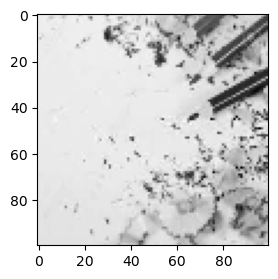

In [29]:
plt.figure(figsize=(3,3))
plt.imshow(train_x[0][0], cmap='gray')
plt.show()

In [30]:
featureSet, labels = caer.sep_train(train_x, IMG_SIZE = (100, 100))

### Normalize the features to (0,1)

In [34]:
from tensorflow.keras.utils import to_categorical
featureSet = caer.normalize(featureSet)


In [36]:
x_train, x_test, y_train, y_test = caer.train_val_split(featureSet, labels, val_ratio=0.2)

In [38]:
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size = 32)

### Reshaping to the right form

In [40]:
x_train = x_train.reshape(len(x_train), 100, 100, 1)
y_train = y_train.reshape(len(y_train), 1)

### Making the model

In [41]:
model = Sequential([
    Conv2D(32, (3,3), activation = 'relu', input_shape = (100, 100, 1)),
    MaxPooling2D((2,2)),
    
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    
    
])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 16928)             0         
                                                                 
 dense (Dense)               (None, 64)                1

In [43]:
from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]

In [44]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

### Training

In [68]:
model.fit(x_train, y_train, epochs = 5, batch_size = 50)

Epoch 1/5
361/361 [==============================] - 4s 10ms/step - loss: 0.6453 - accuracy: 0.6367
Epoch 2/5
361/361 [==============================] - 4s 10ms/step - loss: 0.6279 - accuracy: 0.6541
Epoch 3/5
361/361 [==============================] - 4s 10ms/step - loss: 0.6181 - accuracy: 0.6602
Epoch 4/5
361/361 [==============================] - 4s 10ms/step - loss: 0.6147 - accuracy: 0.6639
Epoch 5/5
361/361 [==============================] - 4s 10ms/step - loss: 0.6106 - accuracy: 0.6644


### Evaluation

In [72]:
model.evaluate(x_test, y_test)

142/142 [==============================] - 1s 4ms/step - loss: 0.6095 - accuracy: 0.6644


[0.6095119714736938, 0.6643775105476379]

### Prediction

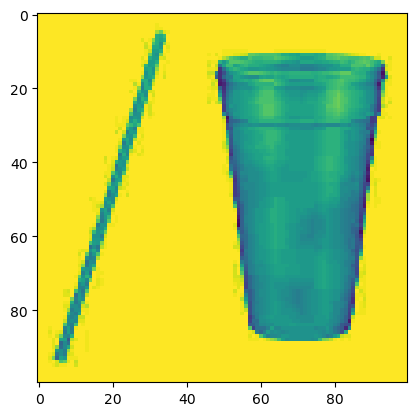

1/1 [==============================] - 0s 29ms/step
Models prediction is Recyclable


In [71]:
# model.evaluate(x_test, y_test)
import random

idx2 = random.randint(0, len(y_test))
plt.imshow(x_test[idx2, :])
plt.show()

y_pred = model.predict(x_test[idx2, :].reshape(-1, 100, 100))
y_pred = y_pred > 0.5

if(y_pred == 0):
    pred = 'Organic'
else:
    pred = 'Recyclable'
    
print(f'Models prediction is {pred}')